Mounted at /content/drive
Summary Statistics:
               Age       Height       Weight         FCVC          NCP  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.312600     1.701677    86.586058     2.419043     2.685628   
std       6.345968     0.093305    26.191172     0.533927     0.778039   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      19.947192     1.630000    65.473343     2.000000     2.658738   
50%      22.777890     1.700499    83.000000     2.385502     3.000000   
75%      26.000000     1.768464   107.430682     3.000000     3.000000   
max      61.000000     1.980000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  Obesity Level  
count  2111.000000  2111.000000  2111.000000    2111.000000  
mean      2.008011     1.010298     0.657866       3.015632  
std       0.612953     0.850592     0.608927       1.952090  
min       1.000000     0.000000     0.0

<Figure size 1200x800 with 0 Axes>

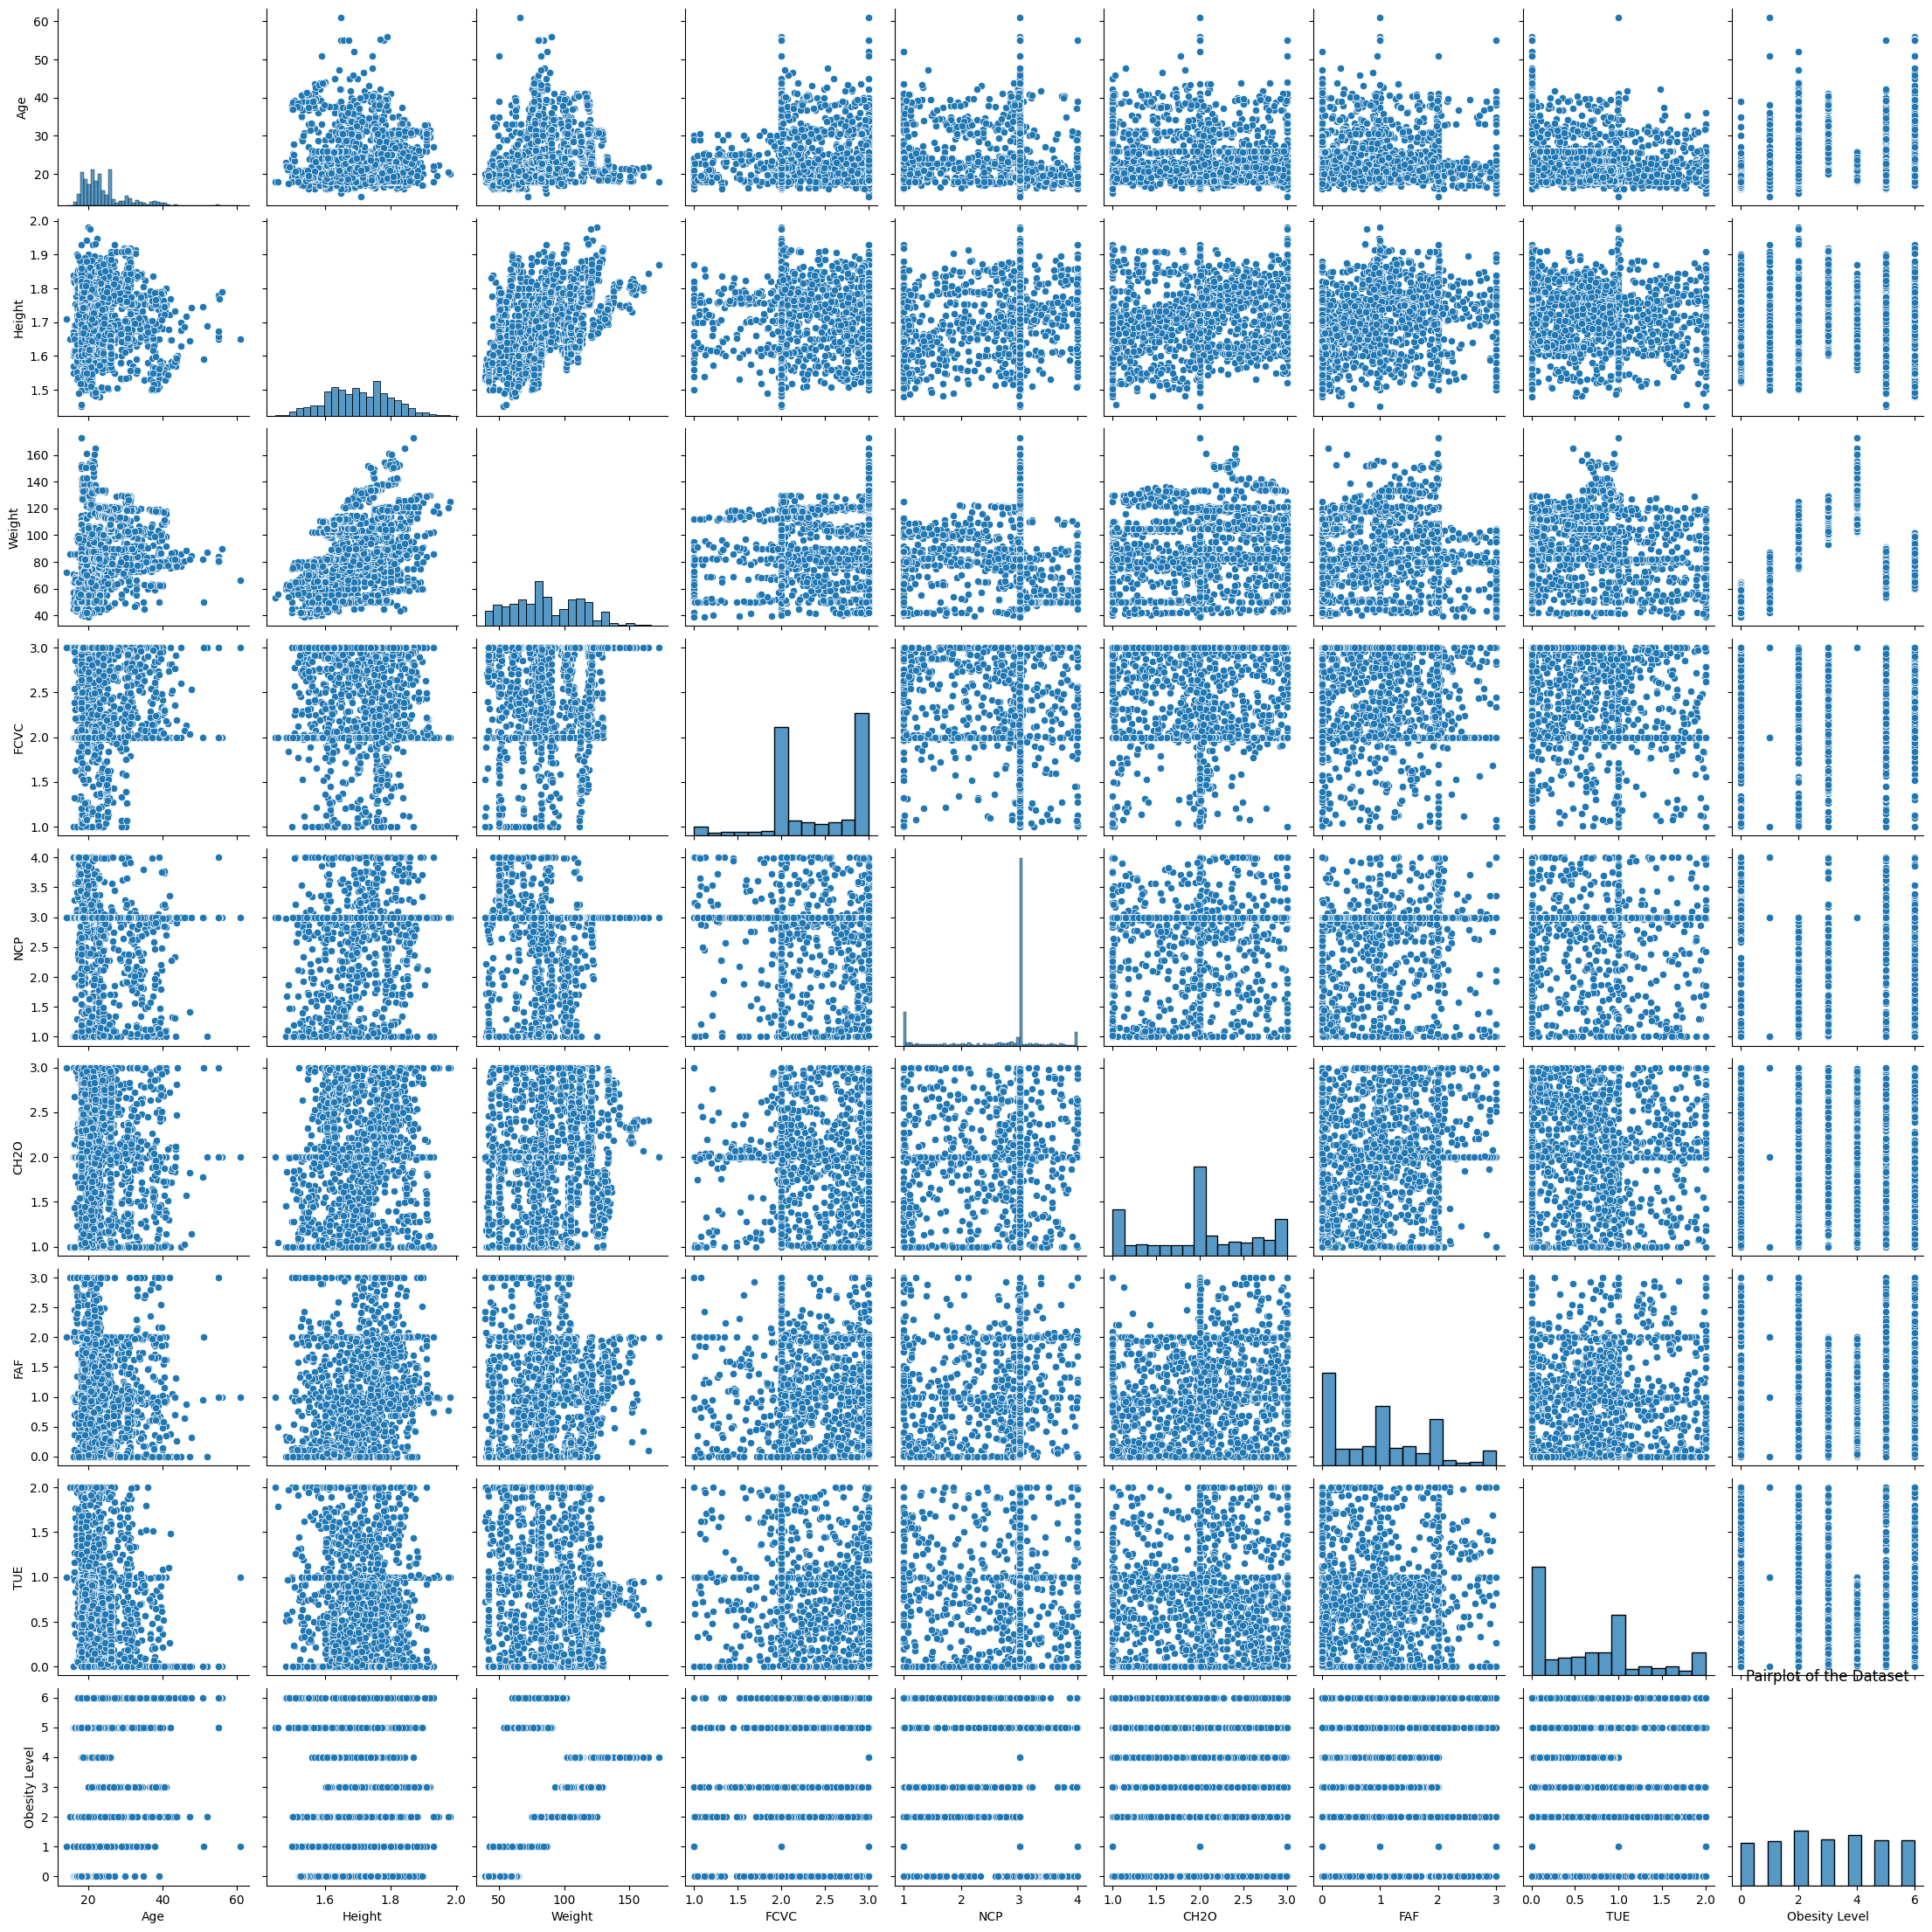


Linear Regression Model Performance:
Train RMSE: 1.6472838500175815
Test RMSE: 1.6481190196350348

Support Vector Regression Model Performance:
Train RMSE: 0.6996648949255031
Test RMSE: 1.060387653290435


In [24]:
#Imports
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

#Attach Google Drive
drive.mount('/content/drive', force_remount=True)

#File path for dataset
data_path = '/content/drive/MyDrive/ObesityDataSet_raw_and_data_sinthetic.csv'

#Load dataset
df = pd.read_csv(data_path)

#Change target variable name
df.rename(columns={'NObeyesdad': 'Obesity Level'}, inplace=True)

#Encode target variable
label_encoder = LabelEncoder()
df['Obesity Level'] = label_encoder.fit_transform(df['Obesity Level'])

#Exploratory Analysis
print("Summary Statistics:")
print(df.describe())

#Visual Exploration
plt.figure(figsize=(12, 8))
sns.pairplot(df)
plt.title('Pairplot of the Dataset')
plt.show()

#Preprocessing
numeric_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'MTRANS']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#Train-Test split
X = df.drop(columns=['Obesity Level'])  # Dropping the target variable
y = df['Obesity Level']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Linear Regression Pipeline
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

#SVR Pipeline with GridSearchCV
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

#Define the parameter grid for SVR
param_grid = {
    'regressor__C': [0.1, 1, 10],
    'regressor__epsilon': [0.1, 0.01, 0.001],
    'regressor__kernel': ['linear', 'rbf']
}

#Grid Search
grid_search = GridSearchCV(svr_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_svr = grid_search.best_estimator_

#Fit models
linear_pipeline.fit(X_train, y_train)
best_svr.fit(X_train, y_train)

#Predictions
y_train_pred_linear = linear_pipeline.predict(X_train)
y_test_pred_linear = linear_pipeline.predict(X_test)

y_train_pred_svr = best_svr.predict(X_train)
y_test_pred_svr = best_svr.predict(X_test)

#Evaluation Metrics - RMSE
train_rmse_linear = np.sqrt(mean_squared_error(y_train, y_train_pred_linear))
test_rmse_linear = np.sqrt(mean_squared_error(y_test, y_test_pred_linear))

train_rmse_svr = np.sqrt(mean_squared_error(y_train, y_train_pred_svr))
test_rmse_svr = np.sqrt(mean_squared_error(y_test, y_test_pred_svr))

print("\nLinear Regression Model Performance:")
print("Train RMSE:", train_rmse_linear)
print("Test RMSE:", test_rmse_linear)

print("\nSupport Vector Regression Model Performance:")
print("Train RMSE:", train_rmse_svr)
print("Test RMSE:", test_rmse_svr)


# Conclusion
#Based on RMSE, the Linear Regression model performs better than the Support Vector Regression model.
#Further analysis could potentially improve model performance.
